Выберем парметры ижикевича, при которых возникает пачечная активность без автоколебаний

[0.001] [0.46] [-45] [2]


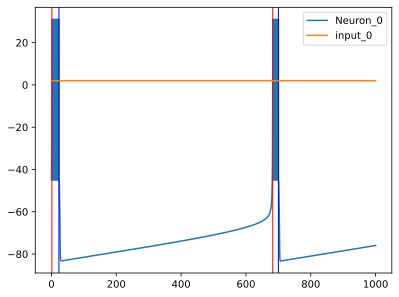

In [2]:
from Izh_net import *
from net_preparation import *
from matplotlib import pyplot as plt
from tqdm import tqdm
%config InlineBackend.figure_formats = ['svg']
def run_net(T, net, I_app):
    """
    Procedure of running network 
    args:
    T - discrete time array
    net - network object
    I_app - applied current
    I_aff - afferents activity
    retrun U, V - state of network array with shape(len(T), N), 
    N - size of
    """
    net.set_init_conditions()
    dt = T[1] - T[0]
    N = len(net)
    U = np.zeros((len(T), N))
    V = np.zeros((len(T), N))
    for i, t in enumerate(T):
        U[i] = net.U_prev
        V[i] = net.V_prev
        net.step(dt=dt, Iapp = I_app[i])
    return U, V
    
N = 1#size of network

def draw_bursts(brusts):
    for x in brusts:
        plt.axvline(x = min(x), ymin=0, ymax=1, color='red', linewidth=1)
        plt.axvline(x = max(x), ymin=0, ymax=1, color='blue', linewidth=1)
    return None
types = ['CH']

A, B, C, D = types2params(types)
A = np.array([0.001])
B = np.array([0.46])
C = np.array([-45])
D = np.array([2])
print(A, B, C, D)
net = Izhikevich_Network(N=N, a=A, b=B, c=C, d=D)

sample_rate = 5
T_max = 1000
T = np.linspace(0, T_max , T_max*sample_rate)
I = np.zeros(N)
I[0] = 2
input = (I)*(T<3000)+ 0*np.random.normal(size=(T_max*sample_rate), scale=4)
I_aff = lambda t: 0
U, V = run_net(T, net, input) 
firings_t, _ = create_firing_rastr(V, T, 30)
bursts = find_bursts(firings_t, T_max)
for i in range(N):
    plt.plot(T, V[:, i], label=f"{net.names[i]}")
    draw_bursts(bursts)
    plt.plot(T, input, label=f'input_{i}')
plt.legend()
plt.show()

Во всех дальнейших опытах завиксируем 
- b = 0.26
- d = 2
- I = 2
- T = 5сек

Проведем анализ частоты пачек в зависимости от параметра a

c = -50 mV

Для локализации пачек используем следующий алгоритм:
1) рассмотрим общее чисто импульсов нейрона fire_t
2) расчитаем интенсивность спайков на всем времени симуляции: $fc = len(fire_t)/T_{max}$
3) Рассчитаем пороговое время для малого пачечного события
   $\tau_c = min(2/(fc), 100)$
4) Проходясь по всем временям спайков будем добавлять в пачку те, расстояния между которыми меньше $\tau_c$

In [3]:
from net_preparation import *
N=1
A = np.array([0.002])
B = np.array([0.26])
C = np.array([-50])
D = np.array([2])
net = Izhikevich_Network(N=N, a=A, b=B, c=C, d=D)
    
    
def draw_bursts(brusts, v):
    for x in brusts:
        plt.axvline(x = min(x), ymin=0, ymax=1, color='red', linewidth=1)
        plt.axvline(x = max(x), ymin=0, ymax=1, color='blue', linewidth=1)
    return None
                   
net.set_params(a=A, b=B, c=C, d=D)
sample_rate = 10
T_max = 7000
I = np.zeros(N)
I[0] = 2
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 0*np.random.normal(size=(T_max*sample_rate), scale=3)
A_vals = np.linspace(0.002, 0.02, 20)
Distance_a = np.zeros((len(A_vals), 2))
duration_a = np.zeros((len(A_vals), 2))
with tqdm(total=len(A_vals)) as pbar:
    for i, a in enumerate(A_vals):
        net.set_params(a = np.array([a]))
        U, V = run_net(T, net, input) 
        firings_t, _ = create_firing_rastr(V, T, 30)
        bursts = find_bursts(firings_t, T_max)
        bursts1 = get_bursts_regions(bursts)
        begin = np.diff(bursts1[:, 0])
        end = np.diff(bursts1[:, 1])
        Distance_a[i, 0] = 0.5*(np.mean(begin) + np.mean(end))
        Distance_a[i, 1] = (np.std(begin) + np.std(end))
        dur = np.mean(bursts1[:, 1] - bursts1[:, 0])
        duration_a[i, 0] = dur
        std = np.std(bursts1[:, 1] - bursts1[:, 0])
        duration_a[i, 1] = std
        #plt.plot(T, V)
        #plt.show()
        # Update the progress bar
        pbar.update(1)
#np.save('burst_distance_noise.npy', Distance)

100%|███████████████████████████████████████████| 20/20 [00:20<00:00,  1.01s/it]


Получили экспоненциальное убывание расстояния между пачками при увеличении параметра а.

$$ distance \approx \frac{1}{-12.4a^2 + 0.8a + 5.5}$$




[-7.24796112e+00  6.55933102e-01  2.70384810e-04]


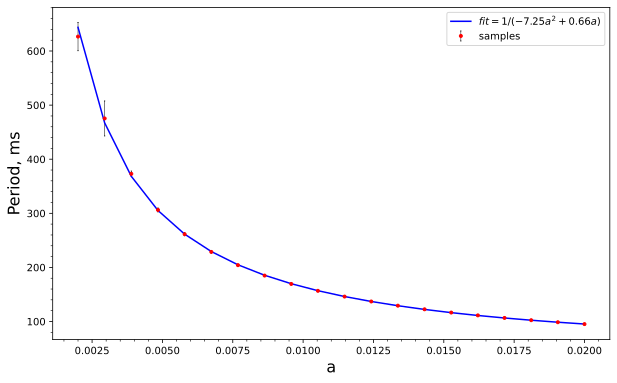

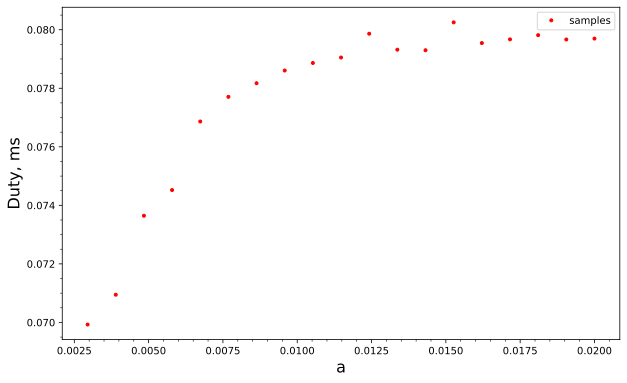

In [38]:
#Distance_noise = np.load('burst_distance_noise.npy')
#Distance = np.load('burst_distance.npy')
model_dist = np.polyfit(A_vals, 1/Distance_a[:, 0], 2)
print(model_dist)
fit_dist = 1/(np.polyval(model_dist, A_vals))

plt.figure(figsize=(10, 6))
plt.errorbar(A_vals[:], Distance_a[:, 0], yerr = Distance_a[:, 1], fmt='.', c='r',
            capsize = 0.5, label = 'samples', ecolor = 'k', elinewidth = 0.5)
plt.plot(A_vals, fit_dist, color='b', label=rf"$fit = 1/({model_dist[0].round(2)}a^2 + {model_dist[1].round(2)}a)$")


plt.ylabel('Period, ms', fontsize=16)
plt.minorticks_on()
plt.xlabel('a', fontsize=16)
plt.legend()
plt.savefig('img/png/burst_period_a.png')
plt.show()

mask_a = A_vals>0.002
model_dur = np.polyfit(A_vals[mask_a], duration_a[mask_a, 0], 2)
#model_noise = np.polyfit(A_vals, 1/Distance[:, 1], 2)

fit_dur = 1/(np.polyval(model_dur, A_vals))

plt.figure(figsize=(10, 6))
plt.errorbar(A_vals[mask_a], 1/duration_a[mask_a, 0], fmt='.', c='r',
             capsize=0.5, label='samples', ecolor='k', elinewidth=0.5)
#plt.plot(A_vals, fit_dur, color='r', label=rf"$fit = 1/({model_dur[0].round(2)}a^2 + {model_dur[1].round(2)}a)$")

plt.ylabel('Duty, ms', fontsize=16)
plt.minorticks_on()
plt.xlabel('a', fontsize=16)
plt.legend()
plt.savefig('img/png/burst_duty_a.png')
plt.show()

In [8]:
A = np.array([0.002])
B = np.array([0.26])
C = np.array([-50])
D = np.array([2])
net.set_params(a=A, b=B, c=C, d=D)
sample_rate = 10
T_max = 7000
T = np.linspace(0, T_max , T_max*sample_rate)
I = np.zeros(N)
I[0] = 2
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 0*np.random.normal(size=(T_max*sample_rate), scale=3)

B_vals = np.linspace(0.19, 0.5, 50)
Distance_b = np.zeros((len(B_vals), 2))
duration_b = np.zeros((len(B_vals), 2))
with tqdm(total=len(B_vals)) as pbar:
    for i, b in enumerate(B_vals):
        net.set_params(b = np.array([b]))
        U, V = run_net(T, net, input) 
        firings_t, _ = create_firing_rastr(V, T, 30)
        bursts = find_bursts(firings_t, T_max)
        bursts1 = get_bursts_regions(bursts)
        begin = np.diff(bursts1[:, 0])
        end = np.diff(bursts1[:, 1])
        Distance_b[i, 0] = 0.5*(np.mean(begin) + np.mean(end))
        Distance_b[i, 1] = (np.std(begin) + np.std(end))
        dur = np.mean(bursts1[:, 1] - bursts1[:, 0])
        duration_b[i, 0] = dur
        std = np.std(bursts1[:, 1] - bursts1[:, 0])
        duration_b[i, 1] = std
        #plt.plot(T, V)
        #plt.show()
        # Update the progress bar
        pbar.update(1)
#np.save('burst_distance_noise.npy', Distance)

/home/nickolai/myvenv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nickolai/myvenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nickolai/myvenv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/nickolai/myvenv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/nickolai/myvenv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 50/50 [00:50<00:00,  1.00s/it]


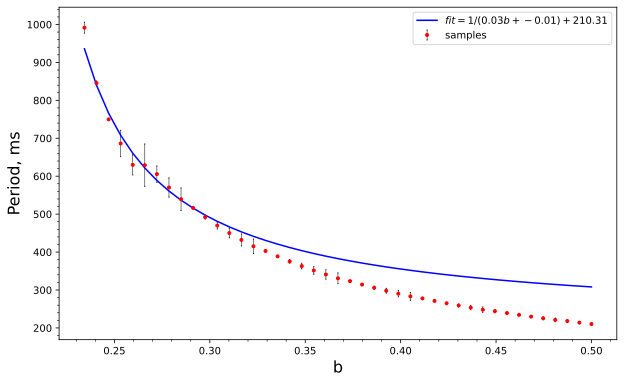

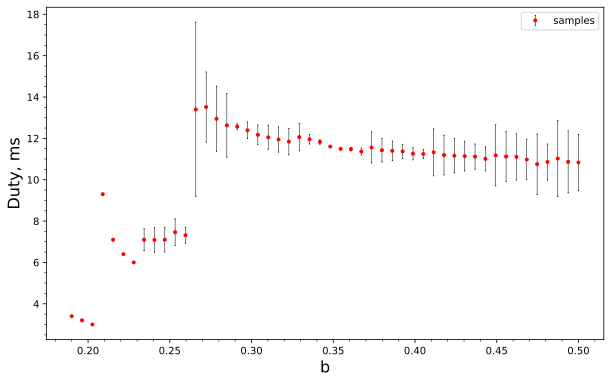

In [37]:
#Distance_noise = np.load('burst_distance_noise.npy')
#Distance = np.load('burst_distance.npy')
mask1 = ~np.isnan(Distance_b[:, 0])
mask2 = B_vals<0.3
mask = np.logical_and(mask1, mask2)
#print(mask)
C = np.min(Distance_b[mask1, 0])
#print(Distance_b[:, 0])
model_dist = np.polyfit(B_vals[mask], 1/(Distance_b[mask, 0] - C), 1)
#print(model_dist)
fit_dist = 1/(np.polyval(model_dist, B_vals[mask1])) + C

plt.figure(figsize=(10, 6))

plt.errorbar(B_vals[mask1], Distance_b[mask1, 0], yerr = Distance_b[mask1, 1], fmt='.', c='r',
                capsize = 0.5, label = 'samples', ecolor = 'k', elinewidth = 0.5)
plt.plot(B_vals[mask1], fit_dist, color='b', label=rf"$fit = 1/({model_dist[0].round(2)}b + {model_dist[1].round(2)}) + {C:.2f}$")


plt.ylabel('Period, ms', fontsize=16)
plt.minorticks_on()
plt.xlabel('b', fontsize=16)
plt.legend()
plt.savefig('img/png/burst_period_b.png', format='png')
plt.show()


#model_dur = np.polyfit(A_vals, duration_b[:, 0], 2)
#fit_dur = 1/(np.polyval(model, A_vals))

plt.figure(figsize=(10, 6))
plt.errorbar(B_vals[:], duration_b[:, 0], yerr=duration_b[:, 1], fmt='.', c='r',
             capsize=0.5, label='samples', ecolor='k', elinewidth=0.5)
#plt.plot(A_vals, fit_dur, color='r', label=rf"$fit = 1/({model_dur[0].round(2)}a^2 + {model_dur[1].round(2)}a)$")

plt.ylabel('Duty, ms', fontsize=16)
plt.minorticks_on()
plt.xlabel('b', fontsize=16)
plt.legend()
plt.savefig('img/png/burst_duty_b.png', format='png')
plt.show()

Рассчитаем зависимость длинны пачки от праметра $c$ - потенциал сброса

In [22]:
sample_rate = 5
T_max = 7000
I = np.zeros(N)
I[0] = 2
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 0*np.random.normal(size=(T_max*sample_rate), scale=4)
A = np.array([0.002])
B = np.array([0.26])
C = np.array([-50])
D = np.array([2])
net.set_params(a=A, b=B, c=C, d=D)

C_vals = np.linspace(-50, -35, 40)
# mean and std of differences between beginings of bursts
Distance_c = np.zeros((len(C_vals), 2))
duration_c = np.zeros((len(C_vals), 2))
with tqdm(total=len(C_vals)) as pbar:
    for i, c in enumerate(C_vals):
        net.set_params(c = np.array([c]))
        U, V = run_net(T, net, input) 
        firings_t, _ = create_firing_rastr(V, T, 30)
        bursts = find_bursts(firings_t, T_max)
        bursts1 = get_bursts_regions(bursts)
        begin = np.diff(bursts1[:, 0])
        end = np.diff(bursts1[:, 1])
        Distance_c[i, 0] = 0.5*(np.mean(begin) + np.mean(end))
        Distance_c[i, 1] = (np.std(begin) + np.std(end))
        dur = np.mean(bursts1[:, 1] - bursts1[:, 0])
        duration_c[i, 0] = dur
        std = np.std(bursts1[:, 1] - bursts1[:, 0])
        duration_c[i, 1] = std
        pbar.update(1)

100%|███████████████████████████████████████████| 40/40 [00:20<00:00,  1.99it/s]


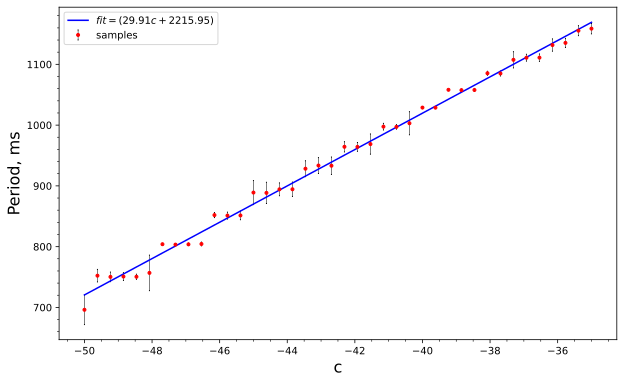

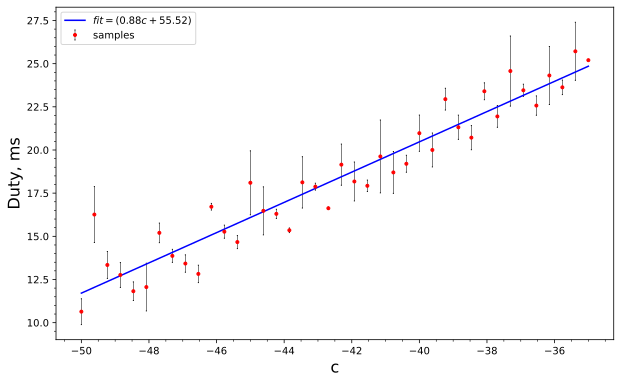

In [36]:
model_dist = np.polyfit(C_vals, Distance_c[:, 0], 1)

fit_dist = (np.polyval(model_dist, C_vals))

plt.figure(figsize=(10, 6))
plt.errorbar(C_vals[:], Distance_c[:, 0], yerr=Distance_c[:, 1], fmt='.', c='r',
             capsize=0.5, label='samples', ecolor='k', elinewidth=0.5)
plt.plot(C_vals, fit_dist, color='b', label=rf"$fit = ({model_dist[0].round(2)}c + {model_dist[1].round(2)})$")


plt.ylabel('Period, ms', fontsize=16)
plt.minorticks_on()
plt.xlabel('c', fontsize=16)
plt.legend()
plt.savefig('img/png/burst_period_c.png', format='png')
plt.show()



model_dur = np.polyfit(C_vals, duration_c[:, 0], 1)
fit_dur = np.polyval(model_dur, C_vals)

plt.figure(figsize=(10, 6))
plt.errorbar(C_vals[:],  duration_c[:, 0], yerr= duration_c[:, 1], fmt='.', c='r',
             capsize=0.5, label='samples', ecolor='k', elinewidth=0.5)

plt.plot(C_vals, fit_dur, color='b', label=rf"$fit = ({model_dur[0].round(2)}c + {model_dur[1].round(2)})$")

plt.ylabel('Duty, ms', fontsize=16)
plt.minorticks_on()
plt.xlabel('c', fontsize=16)
plt.legend()
plt.savefig('img/png/burst_duty_c.png', format='png')
plt.show()


При изменении параметра длинна пачки изменялась по закону:
$$
Duration = 0.8\cdot c + 46.7
$$

Рассчитаем зависимость длинны пачки от праметра $d$ - потенциал сброса

In [29]:
sample_rate = 5
T_max = 7000
I = np.zeros(N)
I[0] = 2
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 0*np.random.normal(size=(T_max*sample_rate), scale=4)
A = np.array([0.001])
B = np.array([0.26])
C = np.array([-50])
D = np.array([2])
net.set_params(a=A, b=B, c=C, d=D)

D_vals = np.linspace(0.1, 1, 40)
# mean and std of differences between beginings of bursts
Distance_d = np.zeros((len(D_vals), 2))
duration_d = np.zeros((len(D_vals), 2))
with tqdm(total=len(D_vals)) as pbar:
    for i, d in enumerate(D_vals):
        net.set_params(d = np.array([d]))
        U, V = run_net(T, net, input) 
        firings_t, _ = create_firing_rastr(V, T, 30)
        bursts = find_bursts(firings_t, T_max)
        bursts1 = get_bursts_regions(bursts)
        begin = np.diff(bursts1[:, 0])
        end = np.diff(bursts1[:, 1])
        Distance_d[i, 0] = 0.5*(np.mean(begin) + np.mean(end))
        Distance_d[i, 1] = (np.std(begin) + np.std(end))
        dur = np.mean(bursts1[:, 1] - bursts1[:, 0])
        duration_d[i, 0] = dur
        std = np.std(bursts1[:, 1] - bursts1[:, 0])
        duration_d[i, 1] = std
        #plt.plot(T, V)
        #draw_bursts(bursts)
        #plt.show()
        pbar.update(1)

100%|███████████████████████████████████████████| 40/40 [00:20<00:00,  1.99it/s]


[0.03898858 0.00028003]


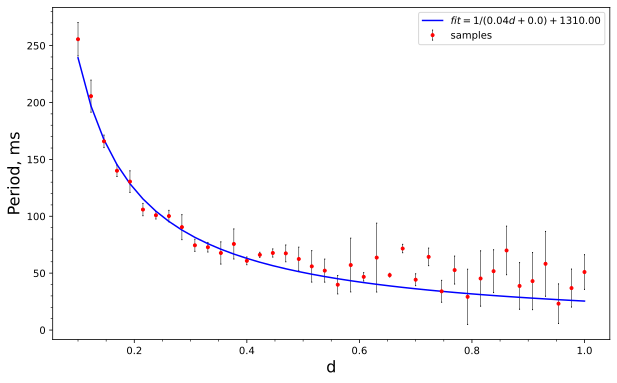

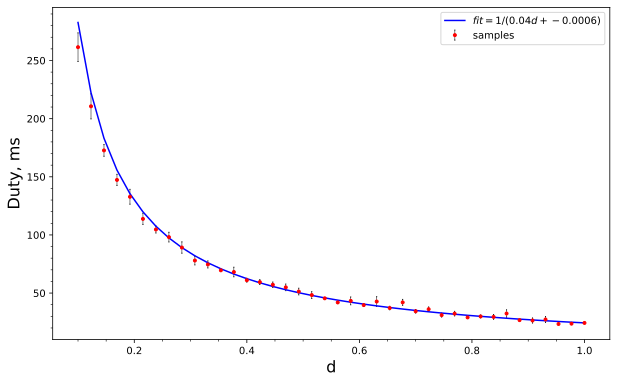

In [35]:
mask_d = D_vals<0.3
C = 1310#np.mean(Distance_d[:, 0])
model_dist = np.polyfit(D_vals[mask_d], 1/(Distance_d[mask_d, 0]-C), 1)
print(model_dist)
fit_dist = 1/(np.polyval(model_dist, D_vals))

plt.figure(figsize=(10, 6))
#plt.scatter(D_vals, (Distance_d[:, 0]))
plt.errorbar(D_vals[:], Distance_d[:, 0]-C, yerr=Distance_d[:, 1], fmt='.', c='r',
             capsize=0.5, label='samples', ecolor='k', elinewidth=0.5)
plt.plot(D_vals, fit_dist, color='b', label=rf"$fit = 1/({model_dist[0].round(2)}d + {model_dist[1].round(2)}) + {C:.2f}$")
plt.ylabel('Period, ms', fontsize=16)
plt.minorticks_on()
plt.xlabel('d', fontsize=16)
plt.legend()
plt.savefig('img/png/burst_period_d.png')
plt.show()



model_dur = np.polyfit(D_vals, 1/duration_d[:, 0], 1)
fit_dur = 1/np.polyval(model_dur, D_vals)

plt.figure(figsize=(10, 6))
plt.errorbar(D_vals[:],  duration_d[:, 0],  yerr= duration_d[:, 1], fmt='.', c='r',
             capsize=0.5, label='samples', ecolor='k', elinewidth=0.5)

plt.plot(D_vals, fit_dur, color='b', label=rf"$fit = 1/({model_dur[0].round(2)}d + {model_dur[1].round(4)})$")
#plt.axvline(-model_dur[1]/model_dur[0], color='g')
plt.ylabel('Duty, ms', fontsize=16)
plt.minorticks_on()
plt.xlabel('d', fontsize=16)
plt.legend()
plt.savefig('img/png/burst_duty_d.png')
plt.show()

При изменении этих параметров попбробуем пустить нормально распределенный шум на нейроны с такими параметрами


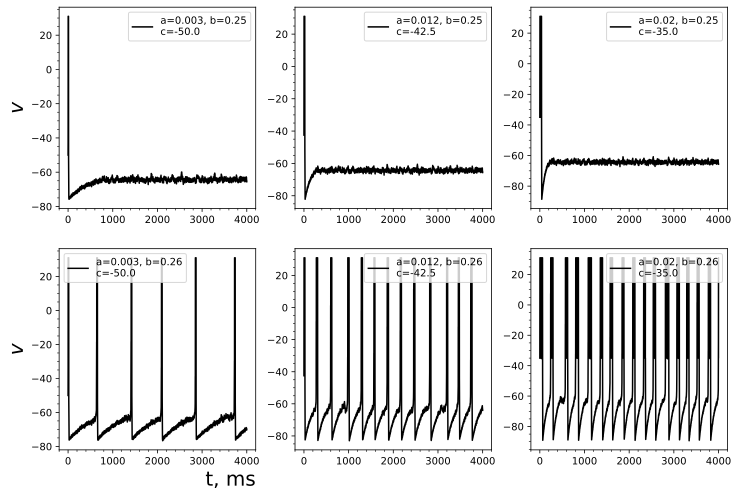

In [39]:
sample_rate = 50
T_max = 4000
I = np.zeros(N)
I[0] = 0
T = np.linspace(0, T_max , T_max*sample_rate)
input = (I)+ 1*np.random.normal(size=(T_max*sample_rate), scale=3)#*(T>1000)
num_samples = 3
A_vals = np.linspace(0.003, 0.02, num_samples)
C_vals = np.linspace(-50, -35, num_samples)
B_vals = np.array([0.25, 0.26])
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for k in range(2):
    for i in range(num_samples):
        net.set_params(a = np.array([A_vals[i]]),
                       c = np.array([C_vals[i]]),
                       b = np.array([B_vals[k]]))
        U, V = run_net(T, net, input) 
        #firings_t, _ = create_firing_rastr(V, T, 30)
        #bursts = find_bursts(firings_t, T_max)
        #bursts1 = get_bursts_regions(bursts)
        #begin = np.diff(bursts1[:, 0])
        #end = np.diff(bursts1[:, 1])
        #Begin_stat[i] = np.mean(begin)
        #End_stat[i] = np.mean(end)
        #ax[k, i].set_title(f'a={a.round(3)}, c={c.round(3)}')
        ax[k, i].plot(T, V, 'k', label=f'a={A_vals[i].round(3)}, b={B_vals[k].round(3)}\nc={C_vals[i].round(3)}')
        #ax1 = ax.twinx()
        #ax1.plot(T, input, 'g')
        #ax1.set_ylabel(r"$I_{app}$")
        if i%3==0:
            ax[k, i].set_ylabel(r'$v$', fontsize=20)
            if k==1:
                ax[k, i].set_xlabel('t, ms', loc='right', fontsize=20)
        ax[k, i].minorticks_on()
        ax[k, i].legend(fontsize=10, loc=0)
        #draw_bursts(bursts, V, T)
plt.savefig(f'./img/png/busrt_noise.png')
plt.show()
        

exp_long_time - симуляции 20000 ms ts=50p/ms шум с дисперсией 4